## Projeto para competição de Kaggle 

# Import's

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Preparar a informação

In [83]:
df = pd.read_csv("C:\\Users\\catar\\Desktop\\Projetos AI\\ML_houseprices\\train.csv")

In [84]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Eliminar Variáveis desnecessárias

In [86]:

df = df.drop(columns=['Id'])

Distribuição dos preços

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Figure size 600x500 with 0 Axes>

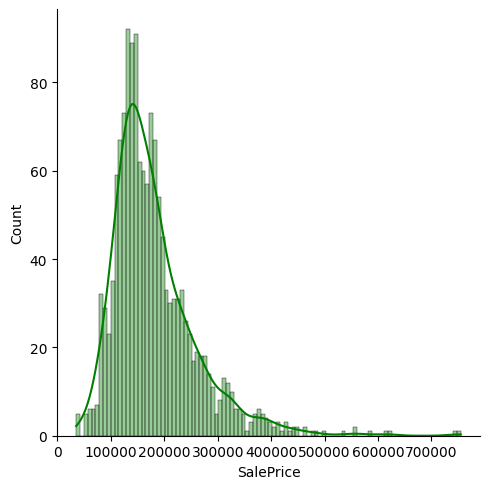

In [87]:
print(df['SalePrice'].describe())
plt.figure(figsize=(6, 5))
sn.displot(df['SalePrice'], color='g', bins=100, alpha=0.4, kde=True);

Lidar com Nulls e fazer Encoding

In [88]:
#Ordinal Encoding: Street,Alley,LotShape,Utilities,LandSlope,ExterQual,ExterCond,BsmtQual
#                  BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,KitchenQual
#                  Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC
#                  Fence

columns_to_encode = ['Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

categories_list = [['Grvl', 'Pave'],
                   ['Grvl', 'Pave'],
                   ['IR3', 'IR2', 'IR1', 'Reg'],
                   ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
                   ['Sev', 'Mod', 'Gtl'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['No', 'Mn', 'Av', 'Gd'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Unf', 'RFn', 'Fin'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['N', 'P', 'Y'],
                   ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                   ['MnWw', 'GdWo', 'MnPrv', 'GdPrv']]

ordinal_encoder = OrdinalEncoder(categories= categories_list,
                                 handle_unknown='use_encoded_value',
                                 unknown_value=-1,
                                 dtype=np.int64)
#Converter para objeto para garantir compatabilidade
df[columns_to_encode] = df[columns_to_encode].astype(object)
df[columns_to_encode] = ordinal_encoder.fit_transform(df[columns_to_encode])
df


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,1,-1,3,Lvl,3,FR2,...,0,-1,-1,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,1,-1,2,Lvl,3,Inside,...,0,-1,-1,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,1,-1,2,Lvl,3,Corner,...,0,-1,-1,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,1,-1,2,Lvl,3,FR2,...,0,-1,-1,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,1,-1,3,Lvl,3,Inside,...,0,-1,2,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,1,-1,3,Lvl,3,Inside,...,0,-1,3,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,1,-1,3,Lvl,3,Inside,...,0,-1,-1,NaN,0,4,2010,WD,Normal,142125


In [89]:
#Target Encoding: MSZoning, LandContour,LotConfig,Neighborhood,Condition1,Condition2,
#                 BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,
#                 MasVnrType,Foundation,Heating,Electrical,GarageType,MiscFeature,SaleType,SaleCondition

columns_to_encode = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
           'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
           'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 
           'SaleType', 'SaleCondition']

kf = KFold(n_splits=3,shuffle=True, random_state=42)
for col in columns_to_encode:
    df[col] = df[col].fillna('Missing')
    global_mean = df.groupby(col)['SalePrice'].mean()
    for data_mean, values_to_fix in kf.split(df):
        data_mean_df, values_to_fix_df = df.iloc[data_mean], df.iloc[values_to_fix]
        target_mean = data_mean_df.groupby(col)['SalePrice'].mean()
        
        #mapeia usando target value mas caso não seja possivel, por falta de casos mapeia com a média global
        mapped_values = values_to_fix_df[col].map(target_mean)
        global_mapped_values = values_to_fix_df[col].map(global_mean)
        filled_values = mapped_values.fillna(global_mapped_values)

        df.loc[values_to_fix, col] = filled_values
    df[col] = df[col].astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   float64
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   Alley          1460 non-null   int64  
 6   LotShape       1460 non-null   int64  
 7   LandContour    1460 non-null   float64
 8   Utilities      1460 non-null   int64  
 9   LotConfig      1460 non-null   float64
 10  LandSlope      1460 non-null   int64  
 11  Neighborhood   1460 non-null   float64
 12  Condition1     1460 non-null   float64
 13  Condition2     1460 non-null   float64
 14  BldgType       1460 non-null   float64
 15  HouseStyle     1460 non-null   float64
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# Análise de variáveis

Correlações

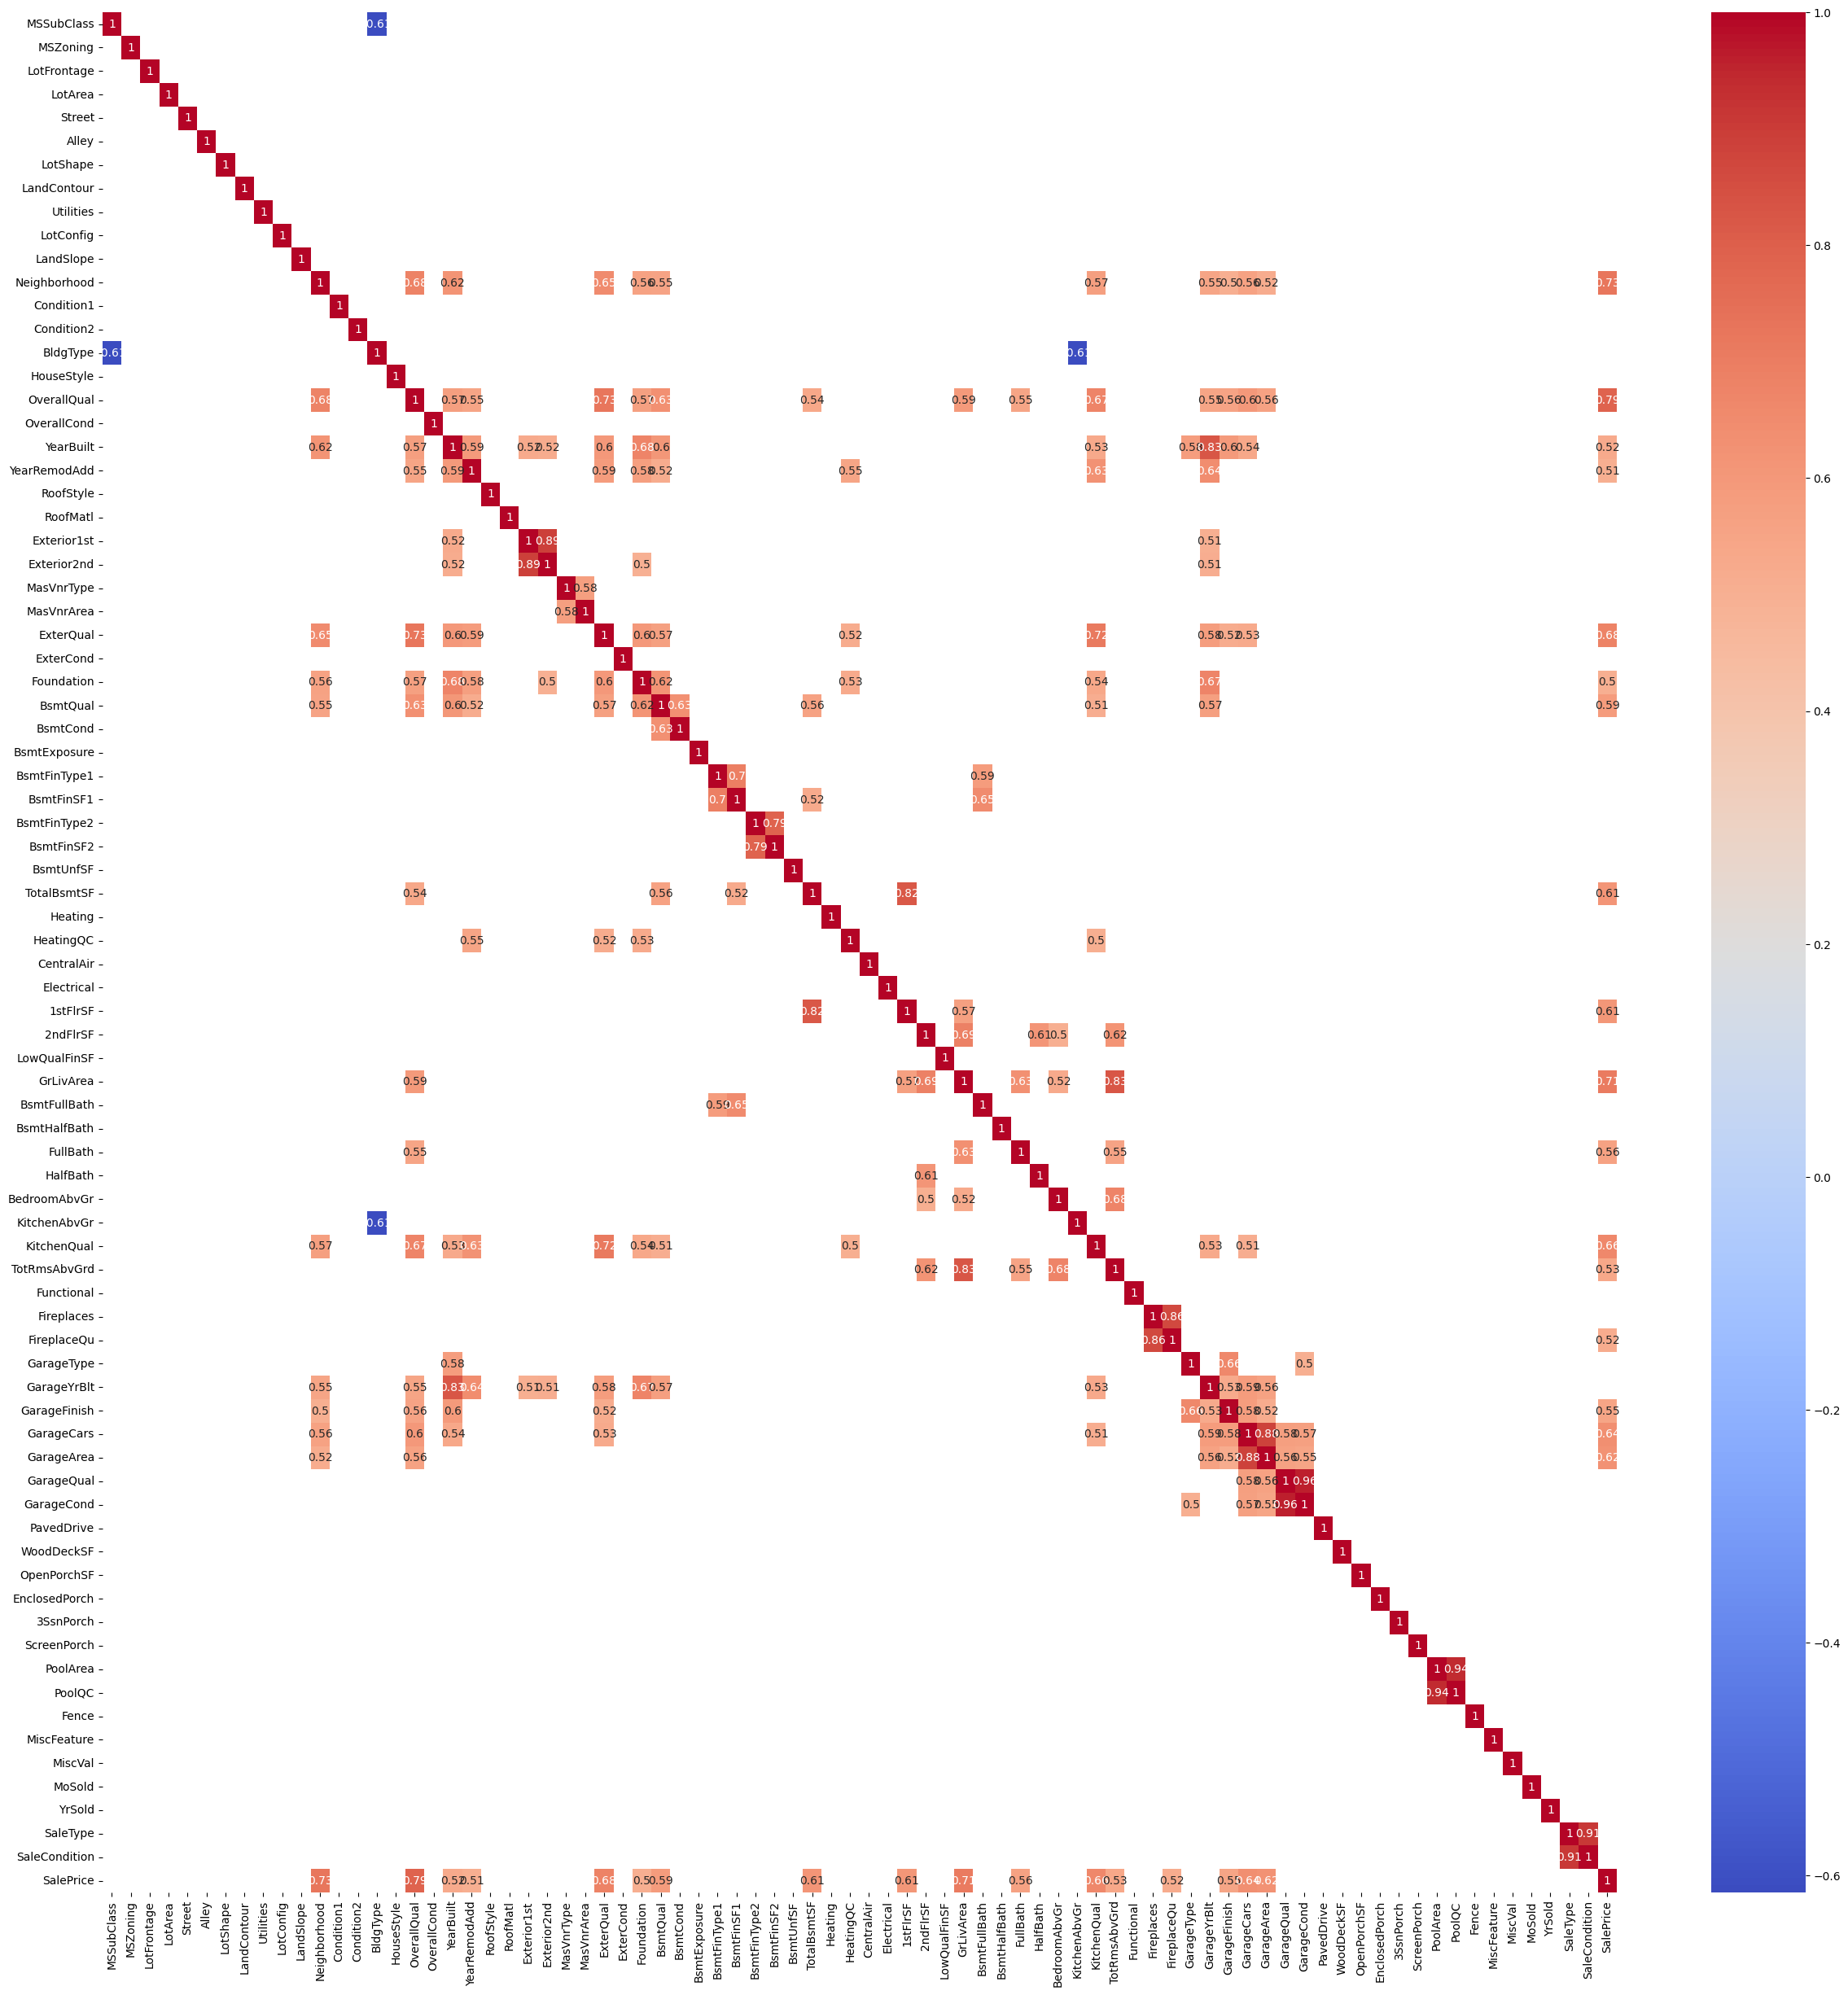

In [90]:
#Variáveis lineares
threshold_corr=0.5
corr_pearson = df.corr(method='pearson')
corr_pearson = corr_pearson[corr_pearson.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_pearson,annot=True,cmap='coolwarm')
plt.show()

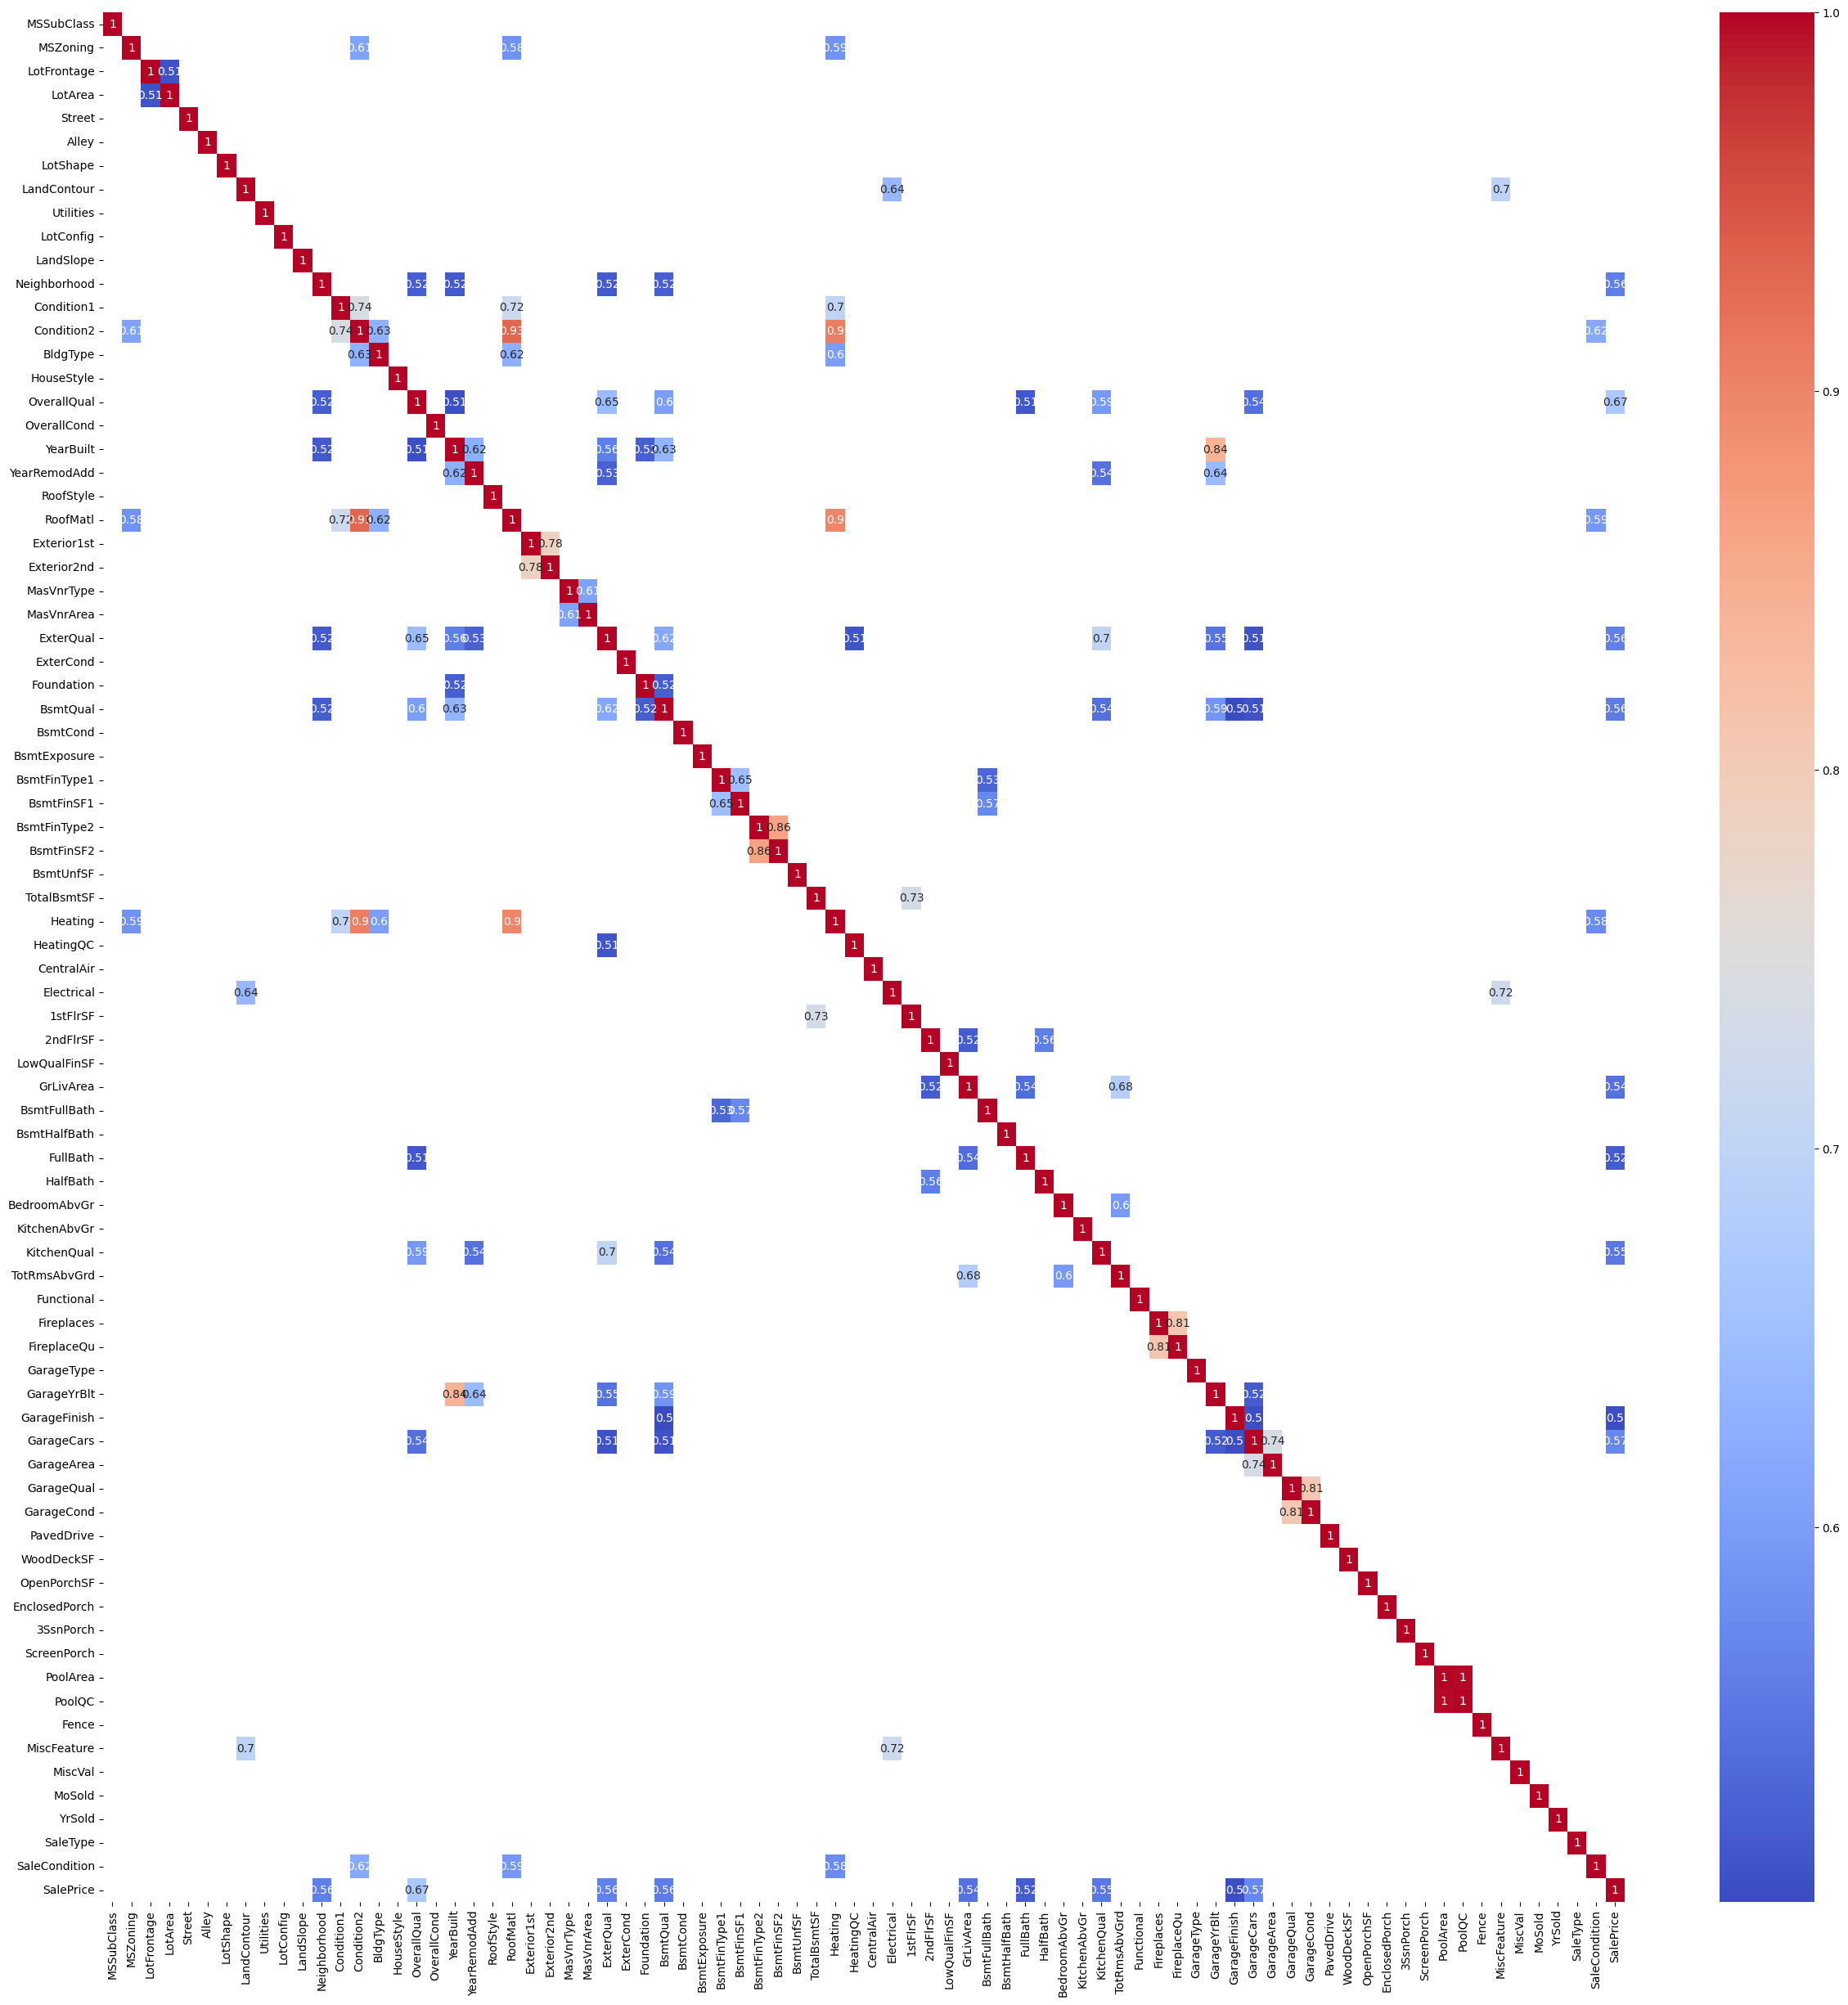

In [91]:
#Variáveis ordinal e categoricas
corr_kendall = df.corr(method='kendall')
corr_kendall = corr_kendall[corr_kendall.abs()> threshold_corr]
plt.figure(figsize=(30, 30))
sn.heatmap(corr_kendall,annot=True,cmap='coolwarm')
plt.show()

Importância

In [92]:
#Random Forest importance

rf = RandomForestRegressor()
x = df.drop(columns=['SalePrice'])
y = df['SalePrice']
rf.fit(x,y)
importances = np.round(rf.feature_importances_,4)

feature_names = df.columns
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df

,Feature,Importance
0,OverallQual,0.5269
1,Neighborhood,0.1030
2,GrLivArea,0.0980
3,TotalBsmtSF,0.0320
4,2ndFlrSF,0.0309
...,...,...
74,PoolQC,0.0002
75,LowQualFinSF,0.0001
76,Utilities,0.0000
77,Street,0.0000


In [93]:
#Permutation importance

results = permutation_importance(rf,x,y,scoring='neg_mean_squared_error')
importances = results.importances_mean
#Normalizar e arredondar valores
importances = np.round((importances / importances.sum()),4)
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = np.array(feature_names)[indices]

importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
importance_df


,Feature,Importance
0,OverallQual,0.4678
1,GrLivArea,0.2002
2,Neighborhood,0.0876
3,TotalBsmtSF,0.0349
4,BsmtFinSF1,0.0282
...,...,...
74,Fence,0.0001
75,LowQualFinSF,0.0001
76,Utilities,0.0000
77,Street,0.0000


In [121]:
#Fazer pipeline com recursive feature deleting and xgboost regressor

X_Train,X_Test,Y_Train,Y_Test = train_test_split(x,y,test_size=0.2,random_state=42)
xgb = XGBRegressor(objective='reg:squarederror',eval_metric='rmse',random_state=42)

pipe = Pipeline([('rfe',RFE(estimator=xgb,n_features_to_select=65)),
                 ('model',xgb)])
param_grid = { 
    'model__n_estimators': [100, 200, 300, 400, 500],           
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],        
    'model__max_depth': [3, 5, 7, 9, 11],                  
    'model__min_child_weight': [1, 3, 5, 7],          
    'model__subsample': [0.7, 0.85, 1.0],              
    'model__colsample_bytree': [0.7, 0.85,  1.0],     
}  
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(X_Train, Y_Train)

print(f"Melhores hyperparameters: {grid_search.best_params_}")
 

Melhores hyperparameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 500, 'model__subsample': 0.85}


In [110]:
X_Train,X_Test,Y_Train,Y_Test = train_test_split(x,y,test_size=0.2,random_state=42)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_Train,Y_Train)
pred = xgb.predict(X_Test)
result = root_mean_squared_error(Y_Test,pred)
print(result)

pipeline_test= Pipeline([('rfe',RFE(n_features_to_select=65,estimator=xgb)),('xgb',xgb)])
pipeline_test.fit(X_Train,Y_Train)
pred2 = pipeline_test.predict(X_Test)

result2 = root_mean_squared_error(Y_Test,pred2)
print(result2)

48048.9691183365
27582.241621479367
27077.055243310835
